# Decision Tree Classifier from sklearn

see: https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html

Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import numpy as np
from sklearn import tree

# For random number generation
from scipy.stats import norm
from scipy.stats import expon

# For plot
import graphviz
from matplotlib import pyplot as plt

### (1) Define generation procedure for "signal" and "background" distributions

In [2]:
# Normal distribution in (R,Phi) with correlation for signal

def mysig(Nmc,pos,sig,corr=0.0):

    data = np.ones(shape=(Nmc,2))
    
    phi = 0.5*np.arcsin(corr)

    g = np.random.normal(size=(2,Nmc))

    r  = pos[0] + sig[0]*(g[0]*np.cos(phi) + g[1]*np.sin(phi))
    th = pos[1] + sig[1]*(g[0]*np.sin(phi) + g[1]*np.cos(phi))

    data[:,0] = r * np.cos(th)
    data[:,1] = r * np.sin(th)
    
    return data

# Exponential distribution with correlation for background

def mybg(Nmc,pos,sig,corr=0.0):

    data = np.ones(shape=(Nmc,2))
    
    phi = 0.5*np.arcsin(corr)

    g = np.random.normal(size=(2,Nmc))

    r1_tab = g[0]*np.cos(phi) + g[1]*np.sin(phi)
    r2_tab = g[0]*np.sin(phi) + g[1]*np.cos(phi)

# Convert correlated gaussian variables r1 & r2 
# to correlated exponential variables, based on survival function

    s1_tab = norm.sf(r1_tab)
    s2_tab = norm.sf(r2_tab)
    
    data[:,0] = pos[0] + sig[0]*expon.isf(s1_tab)
    data[:,1] = pos[1] + sig[1]*expon.isf(s2_tab)
    
    return data

### (2) Generating training and test data

In [3]:
# Sample size

Ntrain = 1000
Ntest = 1000

# Two hypothesis:

# H1: Background - exponential

h1 = np.array([-2.0,-2.0])
sig1 = np.array([2.0,2.0])
corr1 = 0.0

# H2: Signal - normal in (R,phi)

h2 = np.array([1.,0.78])
sig2 = np.array([0.25,1.0])
corr2 = 0.97

# Fraction of signal (h2) hypothesis

fh2 = 0.5

fh1 = 1 - fh2

# Generate train sample 
# ---------------------

h1train = mybg(Ntrain,h1,sig1,corr1)
h2train = mysig(Ntrain,h2,sig2,corr2)

# Uniform distributed numbers

rtrain = np.random.uniform(size=Ntrain)

# Mix of two hypothesis

y_train = rtrain < fh2

y2_train = np.resize(np.repeat(y_train,2),(Ntrain,2))

X_train = y2_train * h2train + (1 - y2_train)*h1train

print("Train data defined, size: ",y_train.size)

# Generate test sample 
# --------------------

h1test = mybg(Ntest,h1,sig1,corr1)
h2test = mysig(Ntest,h2,sig2,corr2)

# Uniform distributed numbers

rtest = np.random.uniform(size=Ntest)

# Mix of two hypothesis

y_test = rtest < fh2

y2_test = np.resize(np.repeat(y_test,2),(Ntest,2))

X_test = y2_test * h2test + (1 - y2_test)*h1test

print("Test data defined, size: ",y_test.size)

# Rescale category from {0,1} to {-1,1}

y_train = 2*y_train - 1
y_test = 2*y_test - 1

Train data defined, size:  1000
Test data defined, size:  1000


### (3) sklearn decision tree classifier

In [30]:
dmax = 4

lmin = 1

clf = tree.DecisionTreeClassifier(max_depth=dmax,min_samples_leaf=lmin)

clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)

print("Number of mislabeled training points out of a total %d points : %d"
        % (X_train.shape[0], (y_train != y_train_pred).sum()))

y_test_pred  = clf.predict(X_test)

print("Number of mislabeled test points out of a total %d points : %d"
        % (X_test.shape[0], (y_test != y_test_pred).sum()))

Number of mislabeled training points out of a total 1000 points : 67
Number of mislabeled test points out of a total 1000 points : 93


In [31]:
dot_data = tree.export_graphviz(clf, out_file=None) 
mygraph = graphviz.Source(dot_data) 

# Render to file:

fname = '13_skTree_'+str(dmax)+'_'+str(lmin)+'_graph'

mygraph.render(fname) 

# mygraph

'13_skTree_4_1_graph.pdf'

### (4) Plot results

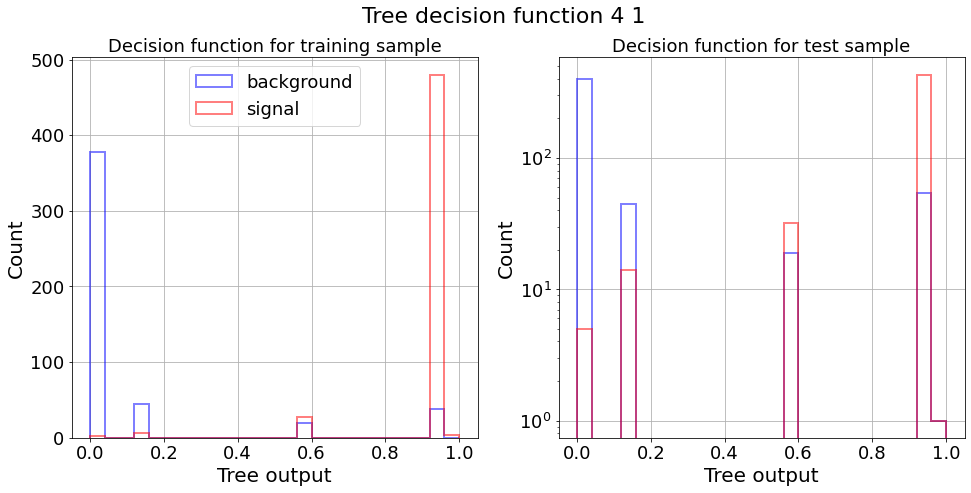

In [32]:
# Distribution of the NN output value

dec_train = clf.predict_proba(X_train)[:, 1]
dec_test = clf.predict_proba(X_test)[:, 1]

Ndec = 25

# From tutorial plot_histogram()
#clf, X_train, y_train)

plt.subplots(1,2,figsize=(16, 7))

plt.suptitle("Tree decision function "+str(dmax)+" "+str(lmin),fontsize=22)

# Train sample

plt.subplot(121)

plt.hist(dec_train[y_train == -1.0], range=[0.,1.],bins=Ndec, log=False, histtype='step', linewidth=2, color="b", alpha=0.5, label='background')
plt.hist(dec_train[y_train == 1.0], range=[0.,1.], bins=Ndec, log=False, histtype='step', linewidth=2, color="r", alpha=0.5, label='signal')
plt.xlim([-0.05,1.05])
plt.legend(loc='upper center',fontsize=18);

plt.xlabel('Tree output',size=20)
plt.ylabel('Count',size=20)
plt.title("Decision function for training sample",size=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')


plt.subplot(122)

plt.hist(dec_test[y_test == -1.0], range=[0.,1.], bins=Ndec, log=True, histtype='step', linewidth=2,  color="b", alpha=0.5, label='background')
plt.hist(dec_test[y_test == 1.0], range=[0.,1.], bins=Ndec,  log=True, histtype='step', linewidth=2,  color="r", alpha=0.5, label='signal')
plt.xlim([-0.05,1.05])

plt.xlabel('Tree output',size=20)
plt.ylabel('Count',size=20)
plt.title("Decision function for test sample",size=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')

fname = '13_skTree_'+str(dmax)+'_'+str(lmin)+'_dec.png'

plt.savefig(fname)

plt.show()



In [33]:
# 2D grid for decision histogram (as background)

Xmin = -2.0
Xmax = 4.0
Nbin = 120
dX = (Xmax-Xmin)/Nbin

Xrange = np.linspace(Xmin+0.5*dX,Xmax-0.5*dX,Nbin)

X1grid, X2grid = np.meshgrid(Xrange,Xrange)

yval = np.empty(X1grid.shape)

# Loop over 2D grid
    
for i in range(Nbin):
    for j in range(Nbin):

        x1 = X1grid[i,j]  
        x2 = X2grid[i,j]      
        
        X = np.array([[x1,x2]])
        yval[i,j]  = clf.predict(X)[0]

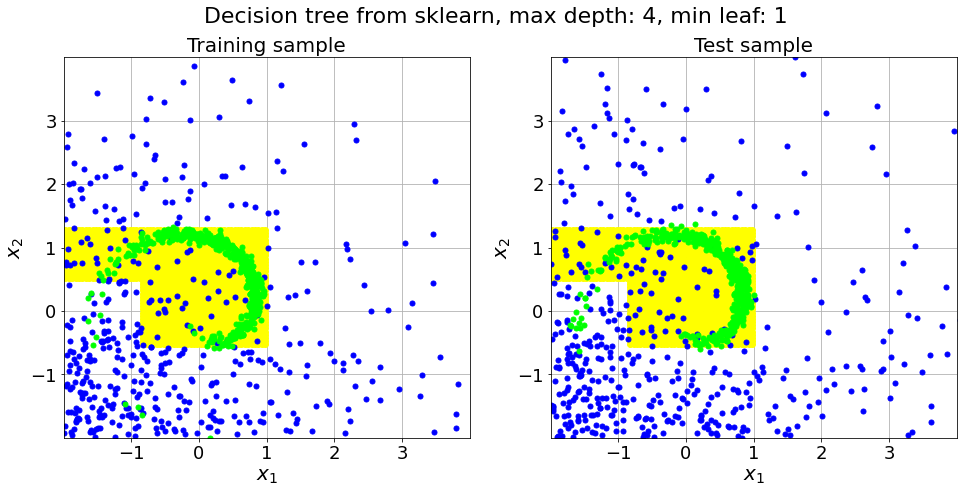

In [34]:
# Create result graph

Xmin = -1.999
Xmax = 3.999

plt.subplots(1,2,figsize=(16, 7))

plt.suptitle("Decision tree from sklearn, max depth: "+str(dmax)+", min leaf: "+str(lmin),fontsize=22)

# Train sample

plt.subplot(121)

# Decision pattern as background

plt.plot(X1grid[yval==1],X2grid[yval==1],'o',color='yellow')
plt.xlim([Xmin,Xmax])
plt.ylim([Xmin,Xmax])

# Training points in two categories

plt.plot(X_train[:,0][y_train==-1],X_train[:,1][y_train==-1],'o',color='blue',ms=5)
plt.plot(X_train[:,0][y_train==1],X_train[:,1][y_train==1],'o',color='lime',ms=5)

plt.title("Training sample",size=20)
plt.xlabel('$x_1$',size=20)
plt.ylabel('$x_2$',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')

# Test sample

plt.subplot(122)

# Decision pattern as background

plt.plot(X1grid[yval==1],X2grid[yval==1],'o',color='yellow')
plt.xlim([Xmin,Xmax])
plt.ylim([Xmin,Xmax])

# Test points in two categories

plt.plot(X_test[:,0][y_test==-1],X_test[:,1][y_test==-1],'o',color='blue',ms=5)
plt.plot(X_test[:,0][y_test==1],X_test[:,1][y_test==1],'o',color='lime',ms=5)

plt.title("Test sample",size=20)
plt.xlabel('$x_1$',size=20)
plt.ylabel('$x_2$',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')


fname = '13_skTree_'+str(dmax)+'_'+str(lmin)+'.png'

plt.savefig(fname)

plt.show()